## Library Import

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from sklearn.naive_bayes import MultinomialNB


import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Data preprocessing

In [2]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral_Pneumonia']
path = r"C:\Users\tejus\Desktop\projects d\Pr project - covid with xray\COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-1.png,Normal,C:\Users\tejus\Desktop\projects d\Pr project -...
1,Normal/images/Normal-10.png,Normal,C:\Users\tejus\Desktop\projects d\Pr project -...
2,Normal/images/Normal-100.png,Normal,C:\Users\tejus\Desktop\projects d\Pr project -...
3,Normal/images/Normal-1000.png,Normal,C:\Users\tejus\Desktop\projects d\Pr project -...
4,Normal/images/Normal-10000.png,Normal,C:\Users\tejus\Desktop\projects d\Pr project -...


In [3]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 21165


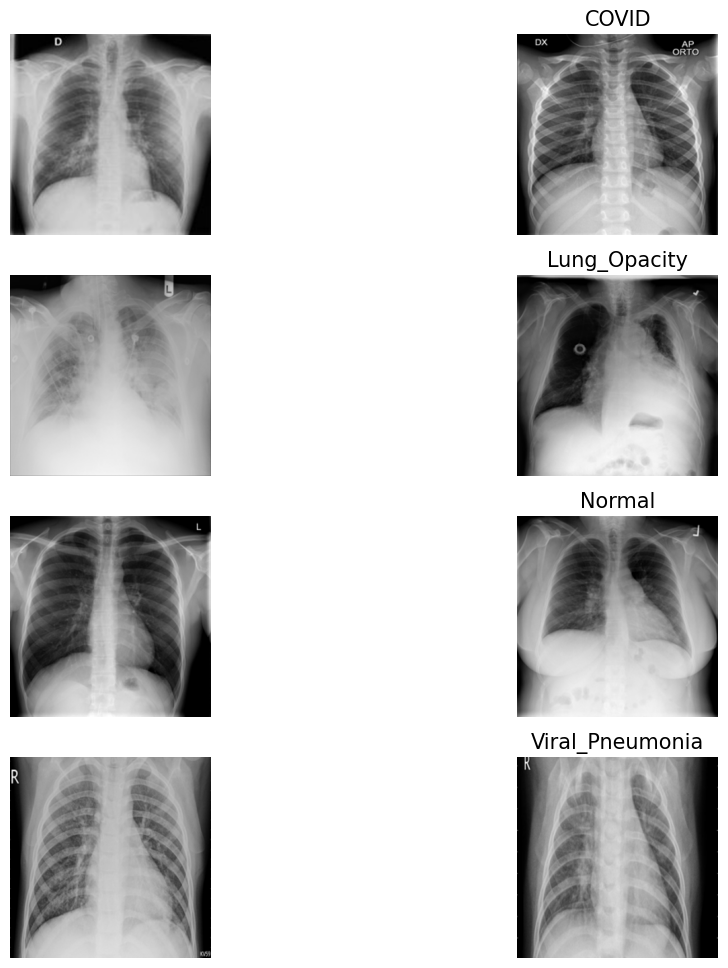

In [4]:
#visualisation 

n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [9]:
print(data['result'].unique())



['Normal', 'COVID', 'Lung_Opacity', 'Viral_Pneumonia']
Categories (4, object): ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [10]:
print(data[data['result'].isnull()])

Empty DataFrame
Columns: [image_file, result, path]
Index: []


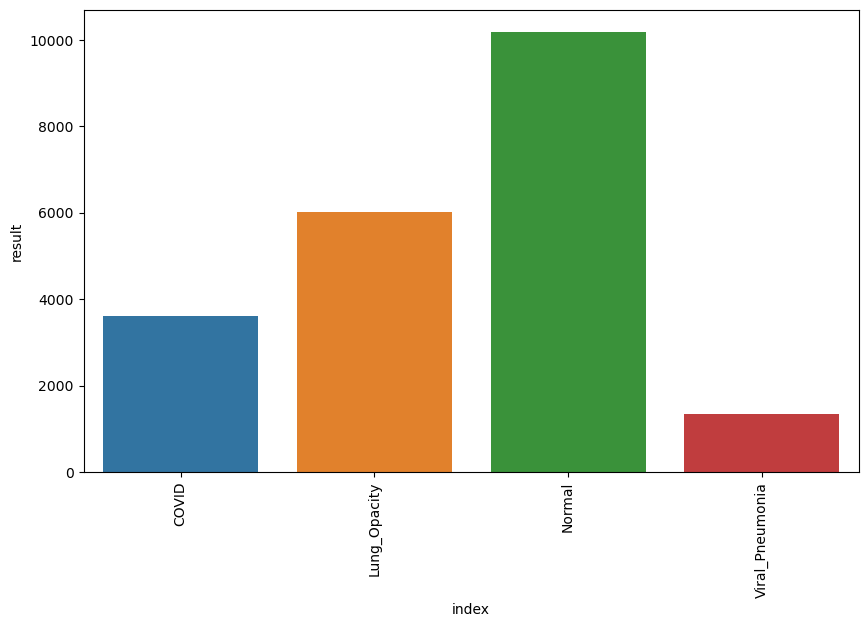

In [14]:
result_counts = data['result'].value_counts().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='result', data=result_counts)
plt.xticks(rotation=90)
plt.show()

In [15]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('Viral_Pneumonia : ', list(data['result']).count('Viral_Pneumonia'))
#10192 images sont normales

Normal :  10192
Covid :  3616
Opacity :  6012
Viral_Pneumonia :  1345


In [16]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral_Pneumonia     6.35
Name: result, dtype: float64

# Classification using pixel feature extraction 

In [17]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [00:43<00:00, 481.43it/s]


In [18]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral_Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 64, 64, 1) (21165,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932,)
(4233,)


In [20]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

In [21]:
input_size = X_train.shape[1] * X_train.shape[2]
print(input_size)

num_classes = len(np.unique(y_train))
print(num_classes)

4096
4


In [22]:
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

* **Machine learning models**

In [24]:


# Create instances of the models
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm_model = svm.SVC(kernel='rbf')
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
kn_clas = KNeighborsClassifier()
log_reg = LogisticRegression()
nb_model = MultinomialNB()

In [25]:
# Train the models
logistic_regression.fit(X_train, y_train)


c:\Users\tejus\miniconda3\envs\myclone\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [27]:
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [28]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [29]:
kn_clas.fit(X_train, y_train)


KNeighborsClassifier()

In [30]:
nb_model.fit(X_train, y_train)


MultinomialNB()

In [31]:
svm_model.fit(X_train, y_train)

SVC()

In [32]:
# Obtain predictions from the models
logistic_regression_preds = logistic_regression.predict(X_test)
decision_tree_preds = decision_tree.predict(X_test)
random_forest_preds = random_forest.predict(X_test)
xgb_model_preds = xgb_model.predict(X_test)
kn_clas_preds = kn_clas.predict(X_test)
nb_model_preds = nb_model.predict(X_test)
svm_model_preds = svm_model.predict(X_test)


In [33]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'xgb_model', 'kn_clas' , 'nb_model' , 'svm_model']
predictions = [logistic_regression_preds, decision_tree_preds, random_forest_preds, xgb_model_preds, kn_clas_preds, nb_model_preds , svm_model_preds]


In [34]:
report_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score', 'Support'])


In [35]:
for model, preds in zip(models, predictions):
    report = classification_report(y_test, preds, output_dict=True)
    
    for class_label, metrics in report.items():
        if class_label != 'accuracy':
            report_df = report_df.append({
                'Model': model,
                'Class': class_label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }, ignore_index=True)


C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarni

In [36]:
report_df

,Model,Class,Precision,Recall,F1-Score,Support
0,Logistic Regression,0,0.770022,0.844455,0.805523,2038
1,Logistic Regression,1,0.611321,0.448133,0.517159,723
2,Logistic Regression,2,0.719064,0.714879,0.716965,1203
3,Logistic Regression,3,0.812500,0.821561,0.817006,269
4,Logistic Regression,macro avg,0.728227,0.707257,0.714163,4233
5,Logistic Regression,weighted avg,0.731133,0.738483,0.731832,4233
6,Decision Tree,0,0.748899,0.750736,0.749816,2038
7,Decision Tree,1,0.587888,0.550484,0.568571,723
8,Decision Tree,2,0.622079,0.641729,0.631751,1203
9,Decision Tree,3,0.617647,0.624535,0.621072,269


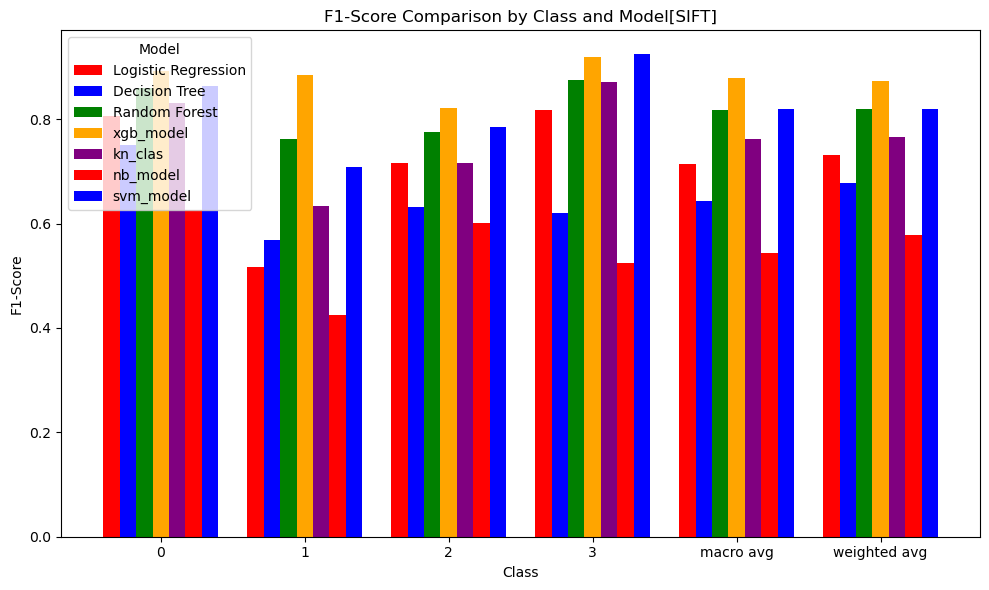

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique class names and models
class_names = report_df['Class'].unique()
model_names = report_df['Model'].unique()

# Set the number of classes and models
num_classes = len(class_names)
num_models = len(model_names)

# Set the width of each bar
bar_width = 0.8

# Set the positions of the bars on the x-axis
positions = np.arange(num_classes)

# Set the colors for the models
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create a dictionary to store the F1-Scores for each class
f1_scores_by_class = {class_name: [] for class_name in class_names}

# Iterate over each row in the dataframe
for _, row in report_df.iterrows():
    class_name = row['Class']
    f1_score = row['F1-Score']
    f1_scores_by_class[class_name].append(f1_score)

# Plot the F1-Scores for each class and model using a grouped bar plot
plt.figure(figsize=(10, 6))

# Iterate over each model
for i, model_name in enumerate(model_names):
    # Get the F1-Scores for the current model
    f1_scores = [f1_scores_by_class[class_name][i] for class_name in class_names]
    # Get the color for the current model
    color = colors[i % len(colors)]
    # Calculate the positions for the current model
    current_positions = positions + (i - num_models / 2 + 0.5) * bar_width / num_models
    # Plot the bars for the current model
    plt.bar(current_positions, f1_scores, width=bar_width / num_models, label=model_name, color=color)

plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison by Class and Model[SIFT]')
plt.xticks(positions, class_names)
plt.legend(title='Model')

plt.tight_layout()
plt.show()

# Classification using IBP feature extration 

In [38]:
# Function to extract LBP features from an image
def extract_lbp_features(image):
    gray = np.array(image)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), range=(0, 59))
    return hist


In [39]:

def process_images():
    features = []
    for filename in tqdm(data['path']):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = Image.open(filename)
            img = ImageOps.grayscale(img)
            img = img.resize((64, 64))
            lbp_features = extract_lbp_features(img)
            features.append(lbp_features)
    
    return features


In [45]:
from skimage.feature import local_binary_pattern


lbp_class_dir = '/kaggle/working/'
lbp_features = process_images()
np.save('lbp_features.npy', lbp_features)

100%|██████████| 21165/21165 [01:12<00:00, 293.11it/s]


In [48]:
lbp_features.shape

(21165, 59)

In [49]:
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral_Pneumonia' : 3})

print(lbp_features.shape, label_img.shape)

(21165, 59) (21165,)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(lbp_features, label_img, 
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16932, 59)
(4233, 59)
(16932,)
(4233,)


In [51]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

In [52]:
# Create instances of the models
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm_model = svm.SVC(kernel='rbf')
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
kn_clas = KNeighborsClassifier()
log_reg = LogisticRegression()
nb_model = MultinomialNB()

In [53]:
# Train the models
logistic_regression.fit(X_train, y_train)

c:\Users\tejus\miniconda3\envs\myclone\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [55]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [56]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [57]:
kn_clas.fit(X_train, y_train)

KNeighborsClassifier()

In [58]:
nb_model.fit(X_train, y_train)

MultinomialNB()

In [59]:
svm_model.fit(X_train, y_train)

SVC()

In [60]:
# Obtain predictions from the models
logistic_regression_preds = logistic_regression.predict(X_test)
decision_tree_preds = decision_tree.predict(X_test)
random_forest_preds = random_forest.predict(X_test)
xgb_model_preds = xgb_model.predict(X_test)
kn_clas_preds = kn_clas.predict(X_test)
nb_model_preds = nb_model.predict(X_test)
svm_model_preds = svm_model.predict(X_test)

In [61]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'xgb_model', 'kn_clas' , 'nb_model' , 'svm_model']
predictions = [logistic_regression_preds, decision_tree_preds, random_forest_preds, xgb_model_preds, kn_clas_preds, nb_model_preds , svm_model_preds]

In [62]:
report_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

In [63]:
for model, preds in zip(models, predictions):
    report = classification_report(y_test, preds, output_dict=True)
    
    for class_label, metrics in report.items():
        if class_label != 'accuracy':
            report_df = report_df.append({
                'Model': model,
                'Class': class_label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }, ignore_index=True)

C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\2844835500.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\2844835500.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\2844835500.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\2844835500.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\2844835500.py:6: Future

In [64]:
report_df

,Model,Class,Precision,Recall,F1-Score,Support
0,Logistic Regression,0,0.621892,0.822375,0.708219,2038
1,Logistic Regression,1,0.347032,0.105118,0.161359,723
2,Logistic Regression,2,0.532313,0.520366,0.526272,1203
3,Logistic Regression,3,0.307692,0.163569,0.213592,269
4,Logistic Regression,macro avg,0.452232,0.402857,0.402360,4233
5,Logistic Regression,weighted avg,0.529521,0.572171,0.531673,4233
6,Decision Tree,0,0.664234,0.669774,0.666992,2038
7,Decision Tree,1,0.406824,0.428769,0.417508,723
8,Decision Tree,2,0.464193,0.447215,0.455546,1203
9,Decision Tree,3,0.439689,0.420074,0.429658,269


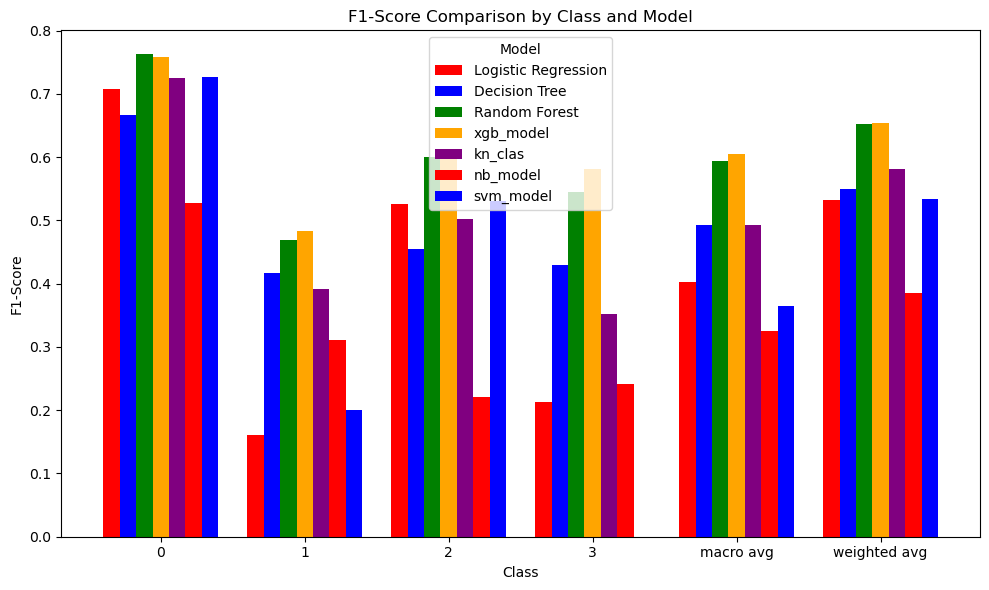

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique class names and models
class_names = report_df['Class'].unique()
model_names = report_df['Model'].unique()

# Set the number of classes and models
num_classes = len(class_names)
num_models = len(model_names)

# Set the width of each bar
bar_width = 0.8

# Set the positions of the bars on the x-axis
positions = np.arange(num_classes)

# Set the colors for the models
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create a dictionary to store the F1-Scores for each class
f1_scores_by_class = {class_name: [] for class_name in class_names}

# Iterate over each row in the dataframe
for _, row in report_df.iterrows():
    class_name = row['Class']
    f1_score = row['F1-Score']
    f1_scores_by_class[class_name].append(f1_score)

# Plot the F1-Scores for each class and model using a grouped bar plot
plt.figure(figsize=(10, 6))

# Iterate over each model
for i, model_name in enumerate(model_names):
    # Get the F1-Scores for the current model
    f1_scores = [f1_scores_by_class[class_name][i] for class_name in class_names]
    # Get the color for the current model
    color = colors[i % len(colors)]
    # Calculate the positions for the current model
    current_positions = positions + (i - num_models / 2 + 0.5) * bar_width / num_models
    # Plot the bars for the current model
    plt.bar(current_positions, f1_scores, width=bar_width / num_models, label=model_name, color=color)

plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison by Class and Model')
plt.xticks(positions, class_names)
plt.legend(title='Model')

plt.tight_layout()
plt.show()

# Classification using HOG feature extration

In [66]:
# Function to extract Hog features from an image
from skimage.feature import hog
def extract_hog_features(image):
    # Convert image to grayscale
    gray = np.array(image)
    
    # Compute HOG features
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True,
                   block_norm='L2-Hys')

    return features

In [67]:
# Function to process all images in a directory and extract SIFT features
def process_images():
    features = []
    for filename in tqdm(data['path']):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = Image.open(filename)
            img = ImageOps.grayscale(img)
            img = img.resize((64, 64))
            Hog_features = extract_hog_features(img)
            features.append(Hog_features)
    
    return features

In [68]:
class_directory = '/kaggle/working/'
class_2_features = process_images()
np.save('class_2_features.npy', class_2_features)

100%|██████████| 21165/21165 [01:41<00:00, 209.29it/s]


In [71]:
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral_Pneumonia': 3})


In [72]:
print(class_2_features.shape, label_img.shape)

(21165, 1764) (21165,)


In [73]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(class_2_features, label_img, 
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16932, 1764)
(4233, 1764)
(16932,)
(4233,)


In [74]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

**machine learning model**

In [75]:
# Create instances of the models
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm_model = svm.SVC(kernel='rbf')
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
kn_clas = KNeighborsClassifier()
log_reg = LogisticRegression()
nb_model = MultinomialNB()

In [76]:
# Train the models
logistic_regression.fit(X_train, y_train)

c:\Users\tejus\miniconda3\envs\myclone\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [77]:
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [78]:
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [79]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [80]:
kn_clas.fit(X_train, y_train)


KNeighborsClassifier()

In [81]:
nb_model.fit(X_train, y_train)


MultinomialNB()

In [82]:
svm_model.fit(X_train, y_train)

SVC()

In [83]:
# Obtain predictions from the models
logistic_regression_preds = logistic_regression.predict(X_test)
decision_tree_preds = decision_tree.predict(X_test)
random_forest_preds = random_forest.predict(X_test)
xgb_model_preds = xgb_model.predict(X_test)
kn_clas_preds = kn_clas.predict(X_test)
nb_model_preds = nb_model.predict(X_test)
svm_model_preds = svm_model.predict(X_test)


In [84]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'xgb_model', 'kn_clas' , 'nb_model' , 'svm_model']
predictions = [logistic_regression_preds, decision_tree_preds, random_forest_preds, xgb_model_preds, kn_clas_preds, nb_model_preds , svm_model_preds]


In [85]:
report_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score', 'Support'])


In [86]:
for model, preds in zip(models, predictions):
    report = classification_report(y_test, preds, output_dict=True)
    
    for class_label, metrics in report.items():
        if class_label != 'accuracy':
            report_df = report_df.append({
                'Model': model,
                'Class': class_label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }, ignore_index=True)


C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append({
C:\Users\tejus\AppData\Local\Temp\ipykernel_9048\750575445.py:6: FutureWarni

In [87]:
report_df


,Model,Class,Precision,Recall,F1-Score,Support
0,Logistic Regression,0,0.845043,0.861629,0.853256,2038
1,Logistic Regression,1,0.725948,0.688797,0.706884,723
2,Logistic Regression,2,0.793478,0.788861,0.791163,1203
3,Logistic Regression,3,0.926740,0.940520,0.933579,269
4,Logistic Regression,macro avg,0.822802,0.819952,0.821221,4233
5,Logistic Regression,weighted avg,0.815239,0.816442,0.815713,4233
6,Decision Tree,0,0.720318,0.711482,0.715873,2038
7,Decision Tree,1,0.410689,0.403873,0.407252,723
8,Decision Tree,2,0.580128,0.601829,0.590779,1203
9,Decision Tree,3,0.636015,0.617100,0.626415,269


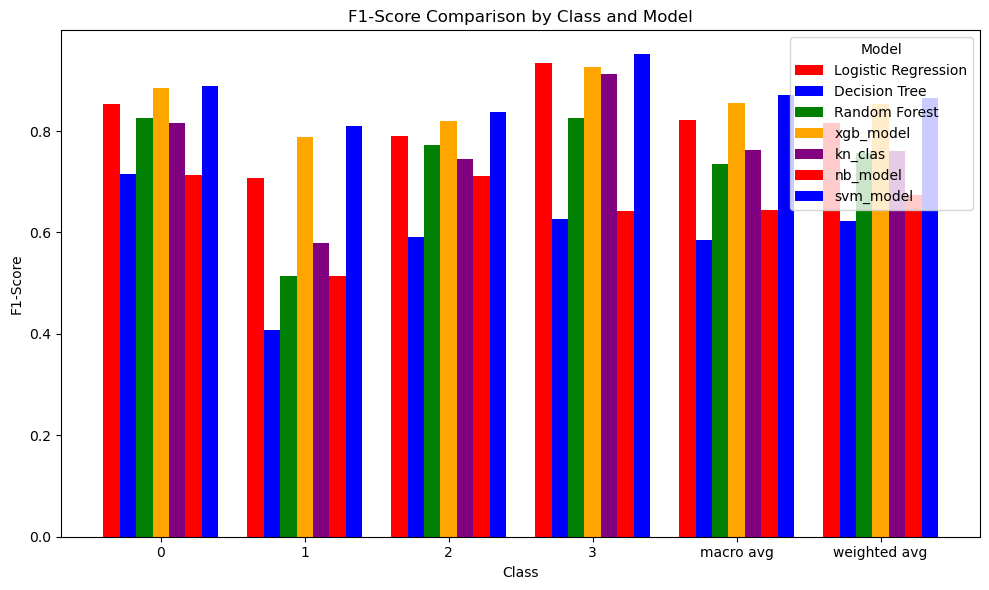

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique class names and models
class_names = report_df['Class'].unique()
model_names = report_df['Model'].unique()

# Set the number of classes and models
num_classes = len(class_names)
num_models = len(model_names)

# Set the width of each bar
bar_width = 0.8

# Set the positions of the bars on the x-axis
positions = np.arange(num_classes)

# Set the colors for the models
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create a dictionary to store the F1-Scores for each class
f1_scores_by_class = {class_name: [] for class_name in class_names}

# Iterate over each row in the dataframe
for _, row in report_df.iterrows():
    class_name = row['Class']
    f1_score = row['F1-Score']
    f1_scores_by_class[class_name].append(f1_score)

# Plot the F1-Scores for each class and model using a grouped bar plot
plt.figure(figsize=(10, 6))

# Iterate over each model
for i, model_name in enumerate(model_names):
    # Get the F1-Scores for the current model
    f1_scores = [f1_scores_by_class[class_name][i] for class_name in class_names]
    # Get the color for the current model
    color = colors[i % len(colors)]
    # Calculate the positions for the current model
    current_positions = positions + (i - num_models / 2 + 0.5) * bar_width / num_models
    # Plot the bars for the current model
    plt.bar(current_positions, f1_scores, width=bar_width / num_models, label=model_name, color=color)

plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison by Class and Model')
plt.xticks(positions, class_names)
plt.legend(title='Model')

plt.tight_layout()
plt.show()